# Ablation Study: Merge Score
In this notebook, we compare ClaP with with different merge scores.

In [49]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [50]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

from aeon.visualisation import plot_critical_difference
from external.MCM import MCM
from wand.image import Image

sns.set_theme()
sns.set_color_codes()

import os
import sys

sys.path.append("../../")

Let's choose a score for evaluation (AMI).

In [51]:
eval_score = "ami_score"

Let's load the scores from the different methods.

In [52]:
classifier = ["cgain", "f1_score", "log_loss", "ami", "hamming_loss", "roc_auc"] # , 

datasets = ["train"] 
methods, dfs = list(), list()

for candidate_name in classifier:
    methods.append((candidate_name, f"{candidate_name}.csv.gz"))

for idx, (name, file_name) in enumerate(methods):
    df = []
    
    for d in datasets:
        df.append(pd.read_csv(f"../../experiments/ablation_study/{d}_{file_name}", compression="gzip")) # usecols=["dataset", eval_score],
    
    df = pd.concat(df)
    df.sort_values(by="dataset", inplace=True)
    dfs.append((name, df))

df_scores = pd.DataFrame()

for name, df in dfs:
    df_scores["dataset"] = df.dataset
    df_scores[name] = df[eval_score]

df_scores.reset_index(drop=True, inplace=True)
df_scores

,dataset,cgain,f1_score,log_loss,ami,hamming_loss,roc_auc
0,DodgerLoopDay,1.000,1.000,1.000,1.000,1.000,1.000
1,EEGRat,0.825,0.909,0.909,0.909,0.909,0.909
2,EEGRat2,0.737,0.737,0.737,0.737,0.737,0.737
3,FaceFour,0.840,0.809,0.809,0.809,0.809,0.840
4,GrandMalSeizures2,0.538,0.954,0.954,0.668,0.954,0.538
5,GreatBarbet1,0.816,0.993,0.993,0.993,0.993,0.816
6,Herring,1.000,1.000,1.000,1.000,1.000,1.000
7,InlineSkate,0.486,0.486,0.486,0.486,0.486,0.486
8,InsectEPG1,0.409,0.668,0.668,0.977,0.668,0.514
9,MelbournePedestrian,0.984,0.557,0.557,0.420,0.557,0.984


Let's calculate the mean/median/std score.

In [53]:
df_scores.iloc[:,1:].mean(axis=0).sort_values(ascending=False).round(3)

cgain           0.805
roc_auc         0.783
ami             0.769
f1_score        0.758
hamming_loss    0.758
log_loss        0.756
dtype: float64

In [54]:
df_scores.iloc[:,1:].median(axis=0).sort_values(ascending=False).round(3)

cgain           0.816
roc_auc         0.810
ami             0.789
f1_score        0.752
log_loss        0.752
hamming_loss    0.752
dtype: float64

In [55]:
df_scores.iloc[:,1:].std(axis=0).sort_values().round(3)

cgain           0.174
roc_auc         0.191
ami             0.221
log_loss        0.225
f1_score        0.228
hamming_loss    0.228
dtype: float64

Let's compute the wins per method.

In [56]:
ranks = df_scores.iloc[:,1:].rank(1, method='min', ascending=False)
means = np.array(ranks.mean(axis=0))
args = np.argsort(means)

In [57]:
for mean, name in zip(means[args], df_scores.columns[1:].to_numpy()[args]):
    print(f"{name}:wins={ranks[ranks[name] == 1].shape[0]} rank={np.round(mean, 1)}")

f1_score:wins=13 rank=1.7
hamming_loss:wins=13 rank=1.7
log_loss:wins=12 rank=1.8
ami:wins=12 rank=2.0
roc_auc:wins=14 rank=2.3
cgain:wins=13 rank=2.3


Let's plot the CD diagram.

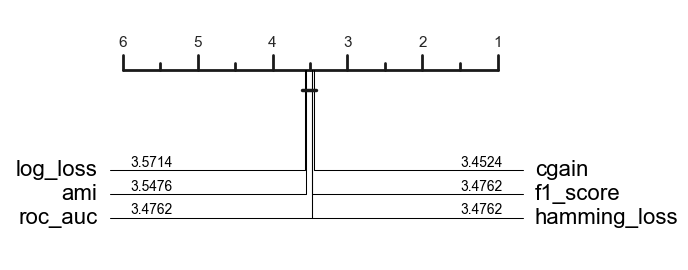

In [58]:
ax = plot_critical_difference(
    scores=df_scores.iloc[:, 1:].to_numpy(),
    labels=df_scores.columns[1:].to_numpy(),
    alpha=0.05,
)

plt.savefig("../../figures/cd_ablation_study_merge_score_train.pdf", bbox_inches="tight")

Let's plot the MCM.

In [59]:
dir_path = "../../figures/"
file_name = "mcm_ablation_study_merge_score_train"

MCM.compare(
    output_dir=dir_path,
    used_statistic="Score",
    save_as_json=False,
    df_results=df_scores.iloc[:, 1:],
    pdf_savename=file_name,
    load_analysis=False,
    pvalue_correction="Holm",
    row_comparates=("cgain",),
    fig_size=(20,5),
    font_size=18,
    precision=3
)
Image(filename=os.path.join(dir_path, file_name + ".pdf"))


Processing cgain, f1_score:   0%|          | 0/6 [00:00<?, ?it/s]/Users/ermshaua/miniconda3/envs/clap/lib/python3.9/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "

Processing f1_score, hamming_loss:   0%|          | 0/6 [00:00<?, ?it/s]

ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

Let's compute wins/losses against cgain.

In [ ]:
selection = "cgain"

for rival in df_scores.columns[1:]:
    if rival == selection: continue

    df_pair = df_scores[[selection, rival]]
    pair_ranks = df_pair.rank(1, method='min', ascending=False)

    wins = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 2)].shape[0]
    losses = pair_ranks[(pair_ranks[selection] == 2) & (pair_ranks[rival] == 1)].shape[0]
    ties = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 1)].shape[0]

    assert wins + losses + ties == pair_ranks.shape[0]

    print(f"{selection} vs {rival}: (wins/ties/losses): {wins}/{ties}/{losses}")

In [ ]:
fontsize = 24
_, ax = plt.subplots(figsize=(15, 5))

# sort by median performance
df_sorted_scores = df_scores[df_scores.iloc[:, 1:].median(axis=0).sort_values().index]

df_sorted_scores.boxplot(ax=ax, rot=90)
ax.set_ylabel("AMI", fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xticklabels(df_sorted_scores.columns, rotation=45, ha="right")
ax.set_yticks(np.round(np.arange(0, 1.0 + .2, .2), 1))

plt.savefig(f"../../figures/bp_ablation_study_merge_score_train.pdf", bbox_inches="tight")